<a href="https://colab.research.google.com/github/RitikaHiremath/DataScience/blob/main/XGBoostUpdated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
import numpy as np

def load_and_label_data(base_path, label, max_files=None):
    combined_100KHzdata = []
    combined_2000KHzdata = []

    file_counter = 0

    for timestamp_folder in os.listdir(base_path):
        if max_files and file_counter >= max_files:
            break

        timestamp_folder_path = os.path.join(base_path, timestamp_folder, "raw")
        timestamp = timestamp_folder.split('_')[0] + '_' + timestamp_folder.split('_')[1]
        timestamp = pd.to_datetime(timestamp, format='%Y.%m.%d_%H.%M.%S')

        # Process 2000KHz data
        df_2000KHz = pd.read_parquet(os.path.join(timestamp_folder_path, "Sampling2000KHz_AEKi-0.parquet"))
        df_2000KHz_grouped = df_2000KHz.groupby(df_2000KHz.index // 10000).mean().reset_index(drop=True)
        df_2000KHz_grouped['timestamp'] = timestamp + pd.to_timedelta(df_2000KHz_grouped.index, unit='ms')
        df_2000KHz_grouped['label'] = label

        # Process 100KHz data
        df_100KHz = pd.read_parquet(os.path.join(timestamp_folder_path, "Sampling100KHz_Irms_Grinding-Grinding spindle current L1-Grinding spindle current L2-Grinding spindle current L3-0.parquet"))
        df_100KHz_grouped = df_100KHz.groupby(df_100KHz.index // 10000).mean().reset_index(drop=True)
        df_100KHz_grouped['timestamp'] = timestamp + pd.to_timedelta(df_100KHz_grouped.index, unit='ms')
        df_100KHz_grouped['label'] = label

        combined_100KHzdata.append(df_100KHz_grouped)
        combined_2000KHzdata.append(df_2000KHz_grouped)

        file_counter += 1

    final_combined_100KHzdata = pd.concat(combined_100KHzdata, ignore_index=True)
    final_combined_2000KHzdata = pd.concat(combined_2000KHzdata, ignore_index=True)

    return final_combined_100KHzdata, final_combined_2000KHzdata

def preprocess_data(ok_data_path, nok_data_path):
    ok_100KHzdata, ok_2000KHzdata = load_and_label_data(ok_data_path, label=0)
    nok_100KHzdata, nok_2000KHzdata = load_and_label_data(nok_data_path, label=1)

    all_100KHzdata = pd.concat([ok_100KHzdata, nok_100KHzdata], ignore_index=True)
    all_2000KHzdata = pd.concat([ok_2000KHzdata, nok_2000KHzdata], ignore_index=True)

    return all_100KHzdata, all_2000KHzdata

def combine_and_interpolate_data(data_100KHz, data_2000KHz):
    # Merge on timestamp
    combined_data = pd.merge_asof(data_100KHz.sort_values('timestamp'),
                                  data_2000KHz.sort_values('timestamp'),
                                  on='timestamp',
                                  by='label',
                                  direction='nearest')

    # Interpolate to fill missing values
    combined_data = combined_data.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')

    return combined_data
def normalize_data(combined_data):
    features = combined_data.drop(columns=['timestamp', 'label'])
    timestamps = combined_data['timestamp']
    labels = combined_data['label']

    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(features)

    normalized_data = pd.DataFrame(normalized_features, columns=features.columns)
    normalized_data.insert(0, 'timestamp', timestamps)
    normalized_data['label'] = labels.values

    return normalized_data


In [20]:
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    y_pred_classes = (y_pred > 0.5).astype("int32")

    # Calculate accuracy precision, recall, and F1 score
    accuracy = accuracy_score (y, y_pred_classes)
    precision = precision_score(y, y_pred_classes)
    recall = recall_score(y, y_pred_classes)
    f1 = f1_score(y, y_pred_classes)

    # Print the classification report
    print(classification_report(y, y_pred_classes))

    # Plot confusion matrix
    cm = confusion_matrix(y, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    return accuracy, precision, recall, f1


In [ ]:
import pandas as pd
from sklearn.utils import shuffle

# Define paths to data
ok_data_path = '/content/gdrive/MyDrive/Data/OK_Measurements'
nok_data_path = '/content/gdrive/MyDrive/Data/NOK_Measurements'

# Preprocess data
all_100KHzdata, all_2000KHzdata = preprocess_data(ok_data_path, nok_data_path)

# Combine and interpolate data
combined_data = combine_and_interpolate_data(all_100KHzdata, all_2000KHzdata)

# Normalize data
normalized_data = normalize_data(combined_data)

# Shuffle the combined data
normalized_data = shuffle(normalized_data, random_state=42)

# normalized_data.head()

,timestamp,Irms_Grinding_rate100000_clipping0_batch0,Grinding spindle current L1_rate100000_clipping0_batch0,Grinding spindle current L2_rate100000_clipping0_batch0,Grinding spindle current L3_rate100000_clipping0_batch0,AEKi_rate2000000_clipping0_batch0,label
11861,2024-02-15 02:40:04.070,1.420169,0.274048,0.048617,-0.293541,-0.570843,1
200,2024-02-14 22:00:10.200,-0.540424,0.389985,0.414758,-0.084475,0.077861,0
10858,2024-02-15 02:37:50.016,-0.785445,0.192536,0.220008,-0.024056,-0.698613,1
10099,2024-02-15 02:35:59.027,-0.996455,0.204749,-0.102606,-0.423757,1.103781,1
3349,2024-02-14 22:07:16.159,-0.066449,0.072114,0.075085,0.050545,-0.116033,0


In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# split the data into train and test data
X=normalized_data.iloc[:,1:-1]
y=normalized_data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 42)

#train the model
xgb_classifier = xgb.XGBClassifier()

xgb_classifier.fit(X_train, y_train)

# make predictions on the test set
y_pred = xgb_classifier.predict(X_test)

####################### dummy steps for geting the metrics

print("Metrics for training data")

y_train_pred = xgb_classifier.predict(X_train)

# calculate accuracy
accuracy = accuracy_score(y_train, y_train_pred)

print("Accuracy:", accuracy)

# calculate precision score
precision = precision_score(y_train, y_train_pred)
print("Precision:", precision)

# recall_score
recall = recall_score(y_train, y_train_pred)
print("recall:", recall)

# f1_score
f1 = f1_score(y_train, y_train_pred)
print("f1:", f1)

####################################################
print("Metrics for test data")

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

# calculate precision score
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# recall_score
recall = recall_score(y_test, y_pred)
print("recall:", recall)

# f1_score
f1 = f1_score(y_test, y_pred)
print("f1:", f1)

Metrics for training data
Accuracy: 0.9449724275489851
Precision: 0.9502487562189055
recall: 0.9286079836233367
f1: 0.9393037401320047
Metrics for test data
Accuracy: 0.8139025725232621
Precision: 0.8042131350681536
recall: 0.7809867629362214
f1: 0.7924297924297923


              precision    recall  f1-score   support

           0       0.94      0.96      0.95      4615
           1       0.95      0.93      0.94      3908

    accuracy                           0.94      8523
   macro avg       0.95      0.94      0.94      8523
weighted avg       0.95      0.94      0.94      8523



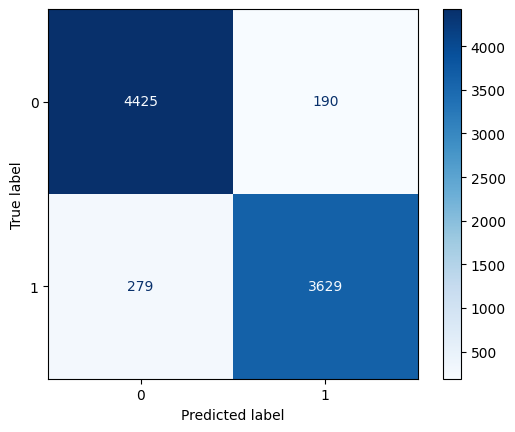

Training Accuracy: 94.50%, Training Precision: 0.95, Training Recall: 0.93, Training F1 Score: 0.94
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1992
           1       0.80      0.78      0.79      1662

    accuracy                           0.81      3654
   macro avg       0.81      0.81      0.81      3654
weighted avg       0.81      0.81      0.81      3654



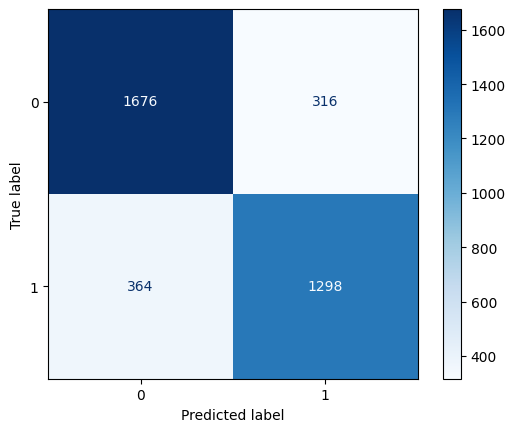

Test Accuracy: 81.39%, Test Precision: 0.80, Test Recall: 0.78, Test F1 Score: 0.79

Results Summary:
    Dataset  Accuracy  Precision    Recall  F1 Score
0  Training  0.944972   0.950249  0.928608  0.939304
1      Test  0.813903   0.804213  0.780987  0.792430


In [23]:
# Evaluate the model on training data
train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(xgb_classifier, X_train, y_train)
print(f"Training Accuracy: {train_accuracy*100:.2f}%, Training Precision: {train_precision:.2f}, Training Recall: {train_recall:.2f}, Training F1 Score: {train_f1:.2f}")

# Evaluate the model on test data
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(xgb_classifier, X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%, Test Precision: {test_precision:.2f}, Test Recall: {test_recall:.2f}, Test F1 Score: {test_f1:.2f}")

# Create a results table
results = {
    "Dataset": ["Training", "Test"],
    "Accuracy": [train_accuracy, test_accuracy],
    "Precision": [train_precision, test_precision],
    "Recall": [train_recall, test_recall],
    "F1 Score": [train_f1, test_f1]
}

results_df = pd.DataFrame(results)
print("\nResults Summary:")
print(results_df)